In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import pandas as pd
import matplotlib as m
from scipy.special import logsumexp

# TDMA Solver

In [ ]:

def solver_TDMA(a,b,c,d):
    '''b---> diagonal numpy array
        a--> lower triangle
        c--> upper triangle
        d--> matrix at right'''
    n=b.shape[0]
    ac,bc,cc,dc=map(np.array,(a,b,c,d)) #creating copy of elements
    # FoRWARD elimination
    for i in range(1,n):
        m=ac[i-1]/bc[i-1]
        bc[i]=bc[i]-m*cc[i-1]
        dc[i]=dc[i]-m*dc[i-1]
    #Backward substitution
    x=np.zeros((n,))
    for i in range(n-1,-1,-1):
        if (i==(n-1)):
            x[n-1]=dc[n-1]/bc[n-1]
        else:
            x[i]=(dc[i]-cc[i]*x[i+1])/bc[i]

    return x

# Project -4 

$$ \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0

In [2]:
def timestep(c,dx):
    dt=dx/c
    return dt

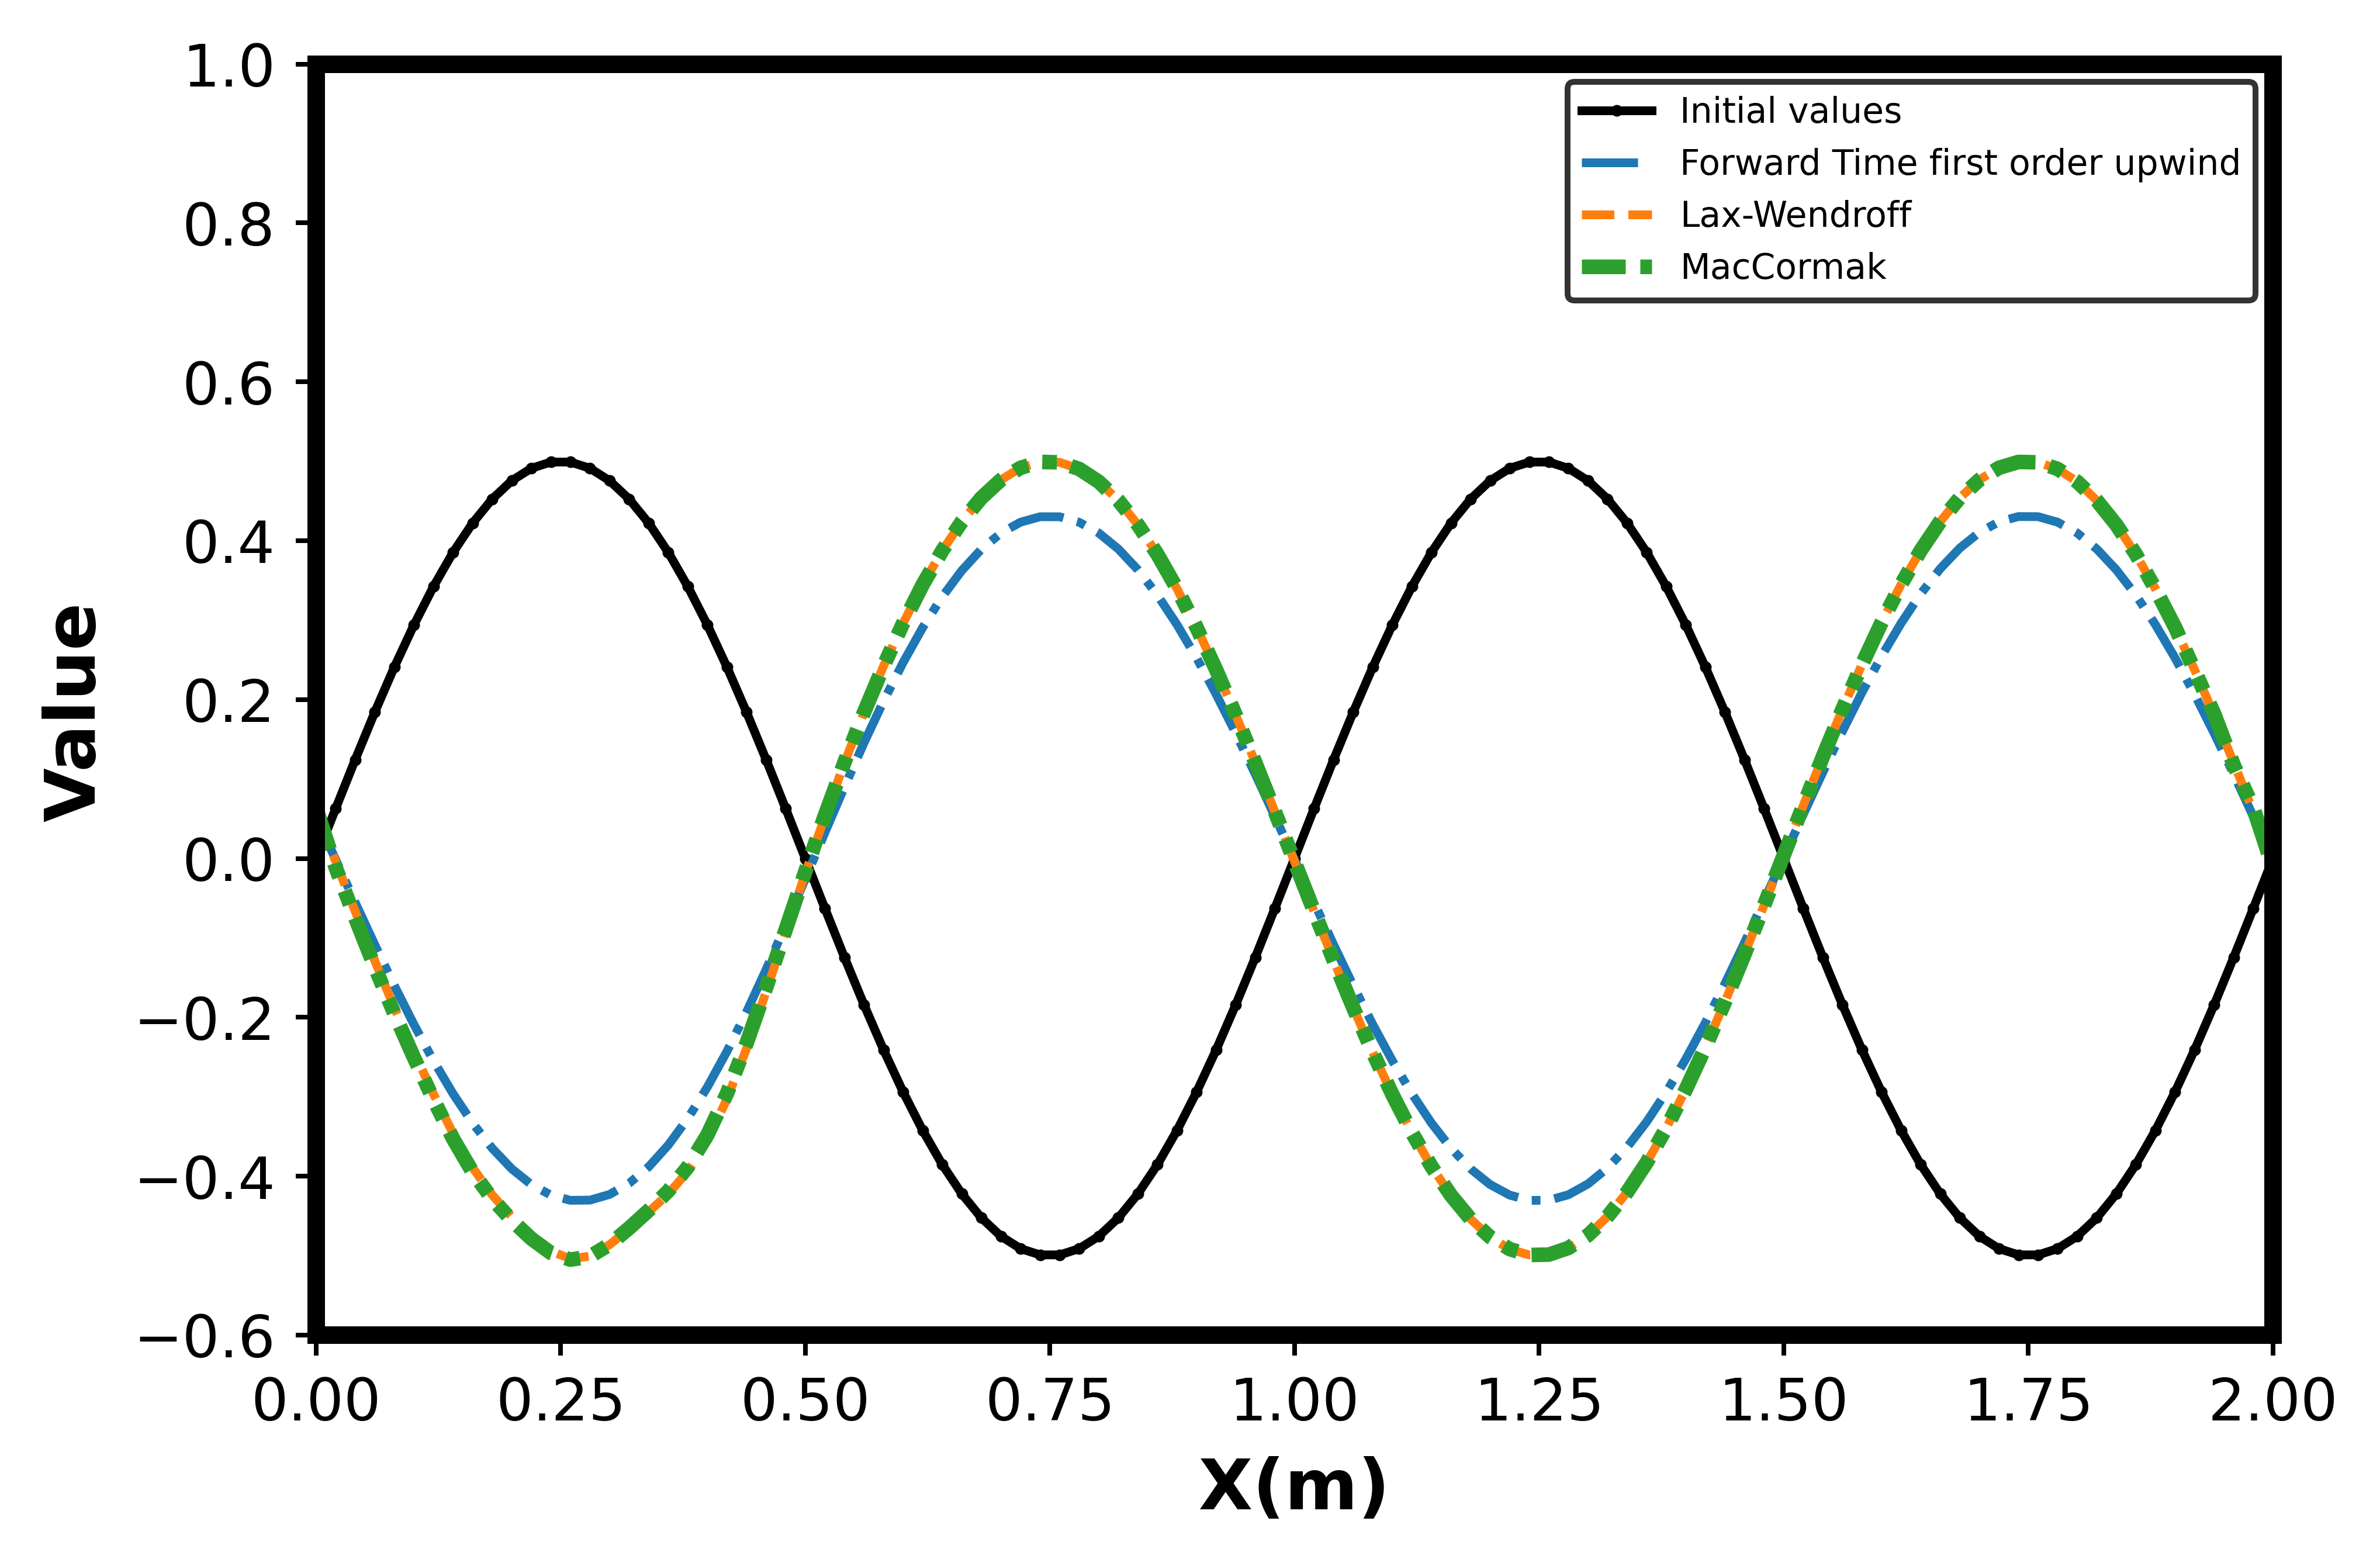

In [3]:
plt.figure(dpi=720)
length=2
nx=101
dx=1/(nx-1)
c=1 # speed
dt=.25*timestep(c,dx)
u_initial = 0.5* np.sin(2*np.pi*np.linspace(0,length,nx))
plt.setp(plt.axes().spines.values(), linewidth=3)
plt.xlabel(' X(m) ',fontsize=12,fontweight='bold')
plt.ylabel('Value ',fontsize=12,fontweight='bold')
plt.xlim(left=0,right=length)
plt.ylim(bottom=-.6,top=1)
nt=100
plt.plot(np.linspace(0,length,nx),u_initial,label='Initial values',color='black',marker='o',markersize=1)
for l in ['FTCS','Forward Time first order upwind','Lax-Wendroff','MacCormak'] :

    u_old=u_initial.copy()
    u=u_old.copy()
    t=0
    if l == 'FTCS':
        while(t<nt):
            for i in range(1,nx-1):
                u[i]=(u_old[i]) - c*(dt/dx)*0.5*(u_old[i+1]-u_old[i-1])
            u[0]=u[nx-2]
            u[nx-1]=u[1]
            u_old=u.copy()
            t=t+1
        #plt.plot(np.linspace(0,length,nx),u,label=l,linewidth=1.5,marker='v',markersize=2)
    if l== 'Forward Time first order upwind':
        while(t<nt):
            for i in range(1,nx-1):
                u[i]=u_old[i] - c*(dt/dx)*(u_old[i]-u_old[i-1])
            u[0]=u[nx-2]
            u[nx-1]=u[1]
            u_old=u.copy()
            t=t+1
        plt.plot(np.linspace(0,length,nx),u,label=l,linestyle='-.',linewidth=1.5)
    if l == 'Lax-Wendroff':
        while(t<nt):
            for i in range(1,nx-1):
                u[i]=u_old[i] - c*0.5*(dt/dx)*(u_old[i+1]-u_old[i-1])+0.5*pow(c*dt/dx,2)*(u_old[i+1]-2*u_old[i]+u_old[i-1])
            u[0]=u[nx-2]
            u[nx-1]=u[1]
            u_old=u.copy()
            t=t+1
        plt.plot(np.linspace(0,length,nx),u,label=l,linestyle='--',linewidth=1.5)
    if l == 'MacCormak':
        u_predictor=u.copy()
        while(t<nt):
            for i in range(1,nx-1):
                #predictor
                u_predictor[i]=u_old[i] - c*(dt/dx)*(u_old[i+1]-u_old[i])
                u_predictor[0]=u_predictor[nx-2]
                u_predictor[nx-1]=u_predictor[1]
                #corrector
                u[i]=(u_old[i]+u_predictor[i])*0.5 - c*0.5*(dt/dx)*(u_predictor[i]-u_predictor[i-1])
            u[0]=u[nx-2]
            u[nx-1]=u[1]
            u_old=u.copy()
            t=t+1
        plt.plot(np.linspace(0,length,nx),u,label=l,linestyle=(0, (3, 1, 1, 1, 1, 1)),linewidth=2.5)


plt.legend(edgecolor='black',loc='upper right',fontsize=6)


$$ \frac{\partial u}{\partial t} + (\frac{1}{2}- u )\frac{\partial u}{\partial x}= 0.01 \frac{\partial^2 u}{\partial x^2}


In [4]:
def delta_t(u,dx,nu,c,b):
    ''' 0.000001 so that to prevent division by zero'''
    #dt=min(pow(dx,2)/(2*nu),dx/(b*abs(max(u))+c+0.000001))
    dt=min(pow(dx,2)/(2*nu),dx/max(((b*u+c)+0.000001)))
    return dt


In [5]:
def F(u,c,b):
    f=c*u + b*pow(u,2)/2
    return f

In [10]:
def MAcCormack(length,nx,u_initial,c,b,nu,time):
    dx=length/(nx-1)
    u_old=u_initial.copy()
    u=u_old.copy()
    u_predictor=u.copy()
    dt=delta_t(u,dx,nu,c,b)
    t=0
    while (t<time):
        #predictor
        for i in range(1,nx-1):
            u_predictor[i]=u_old[i]-(dt/(dx))*(F(u_old[i+1],c,b)-F(u_old[i],c,b))+ 0.5*(nu*dt/(pow(dx,2)))*(u_old[i+1]-2*(u_old[i])+u_old[i-1])
        u_predictor[0]=0
        u_predictor[nx-1]=0
        #corrector
        for i in range(1,nx-1):
            u[i]=(u_old[i]+u_predictor[i])*0.5 -0.5*(dt/(dx))*(F(u_predictor[i],c,b)-F(u_predictor[i-1],c,b)) + 0.5*(nu*dt/(pow(dx,2)))*(u_predictor[i+1]-2*(u_predictor[i])+u_predictor[i-1])
            
        u[0]=0
        u[nx-1]=0
        dt=delta_t(u,dx,nu,c,b)

        u_old=u.copy()
        t=t+dt
    return u,t,dx

In [11]:
length=10
nx=101
u_initial=0.5*np.exp((-1)*np.power(np.linspace(0,length,nx)-(length/2),2))

u,t,dx= MAcCormack(10,101,u_initial,1/2,-1,0.01,5)

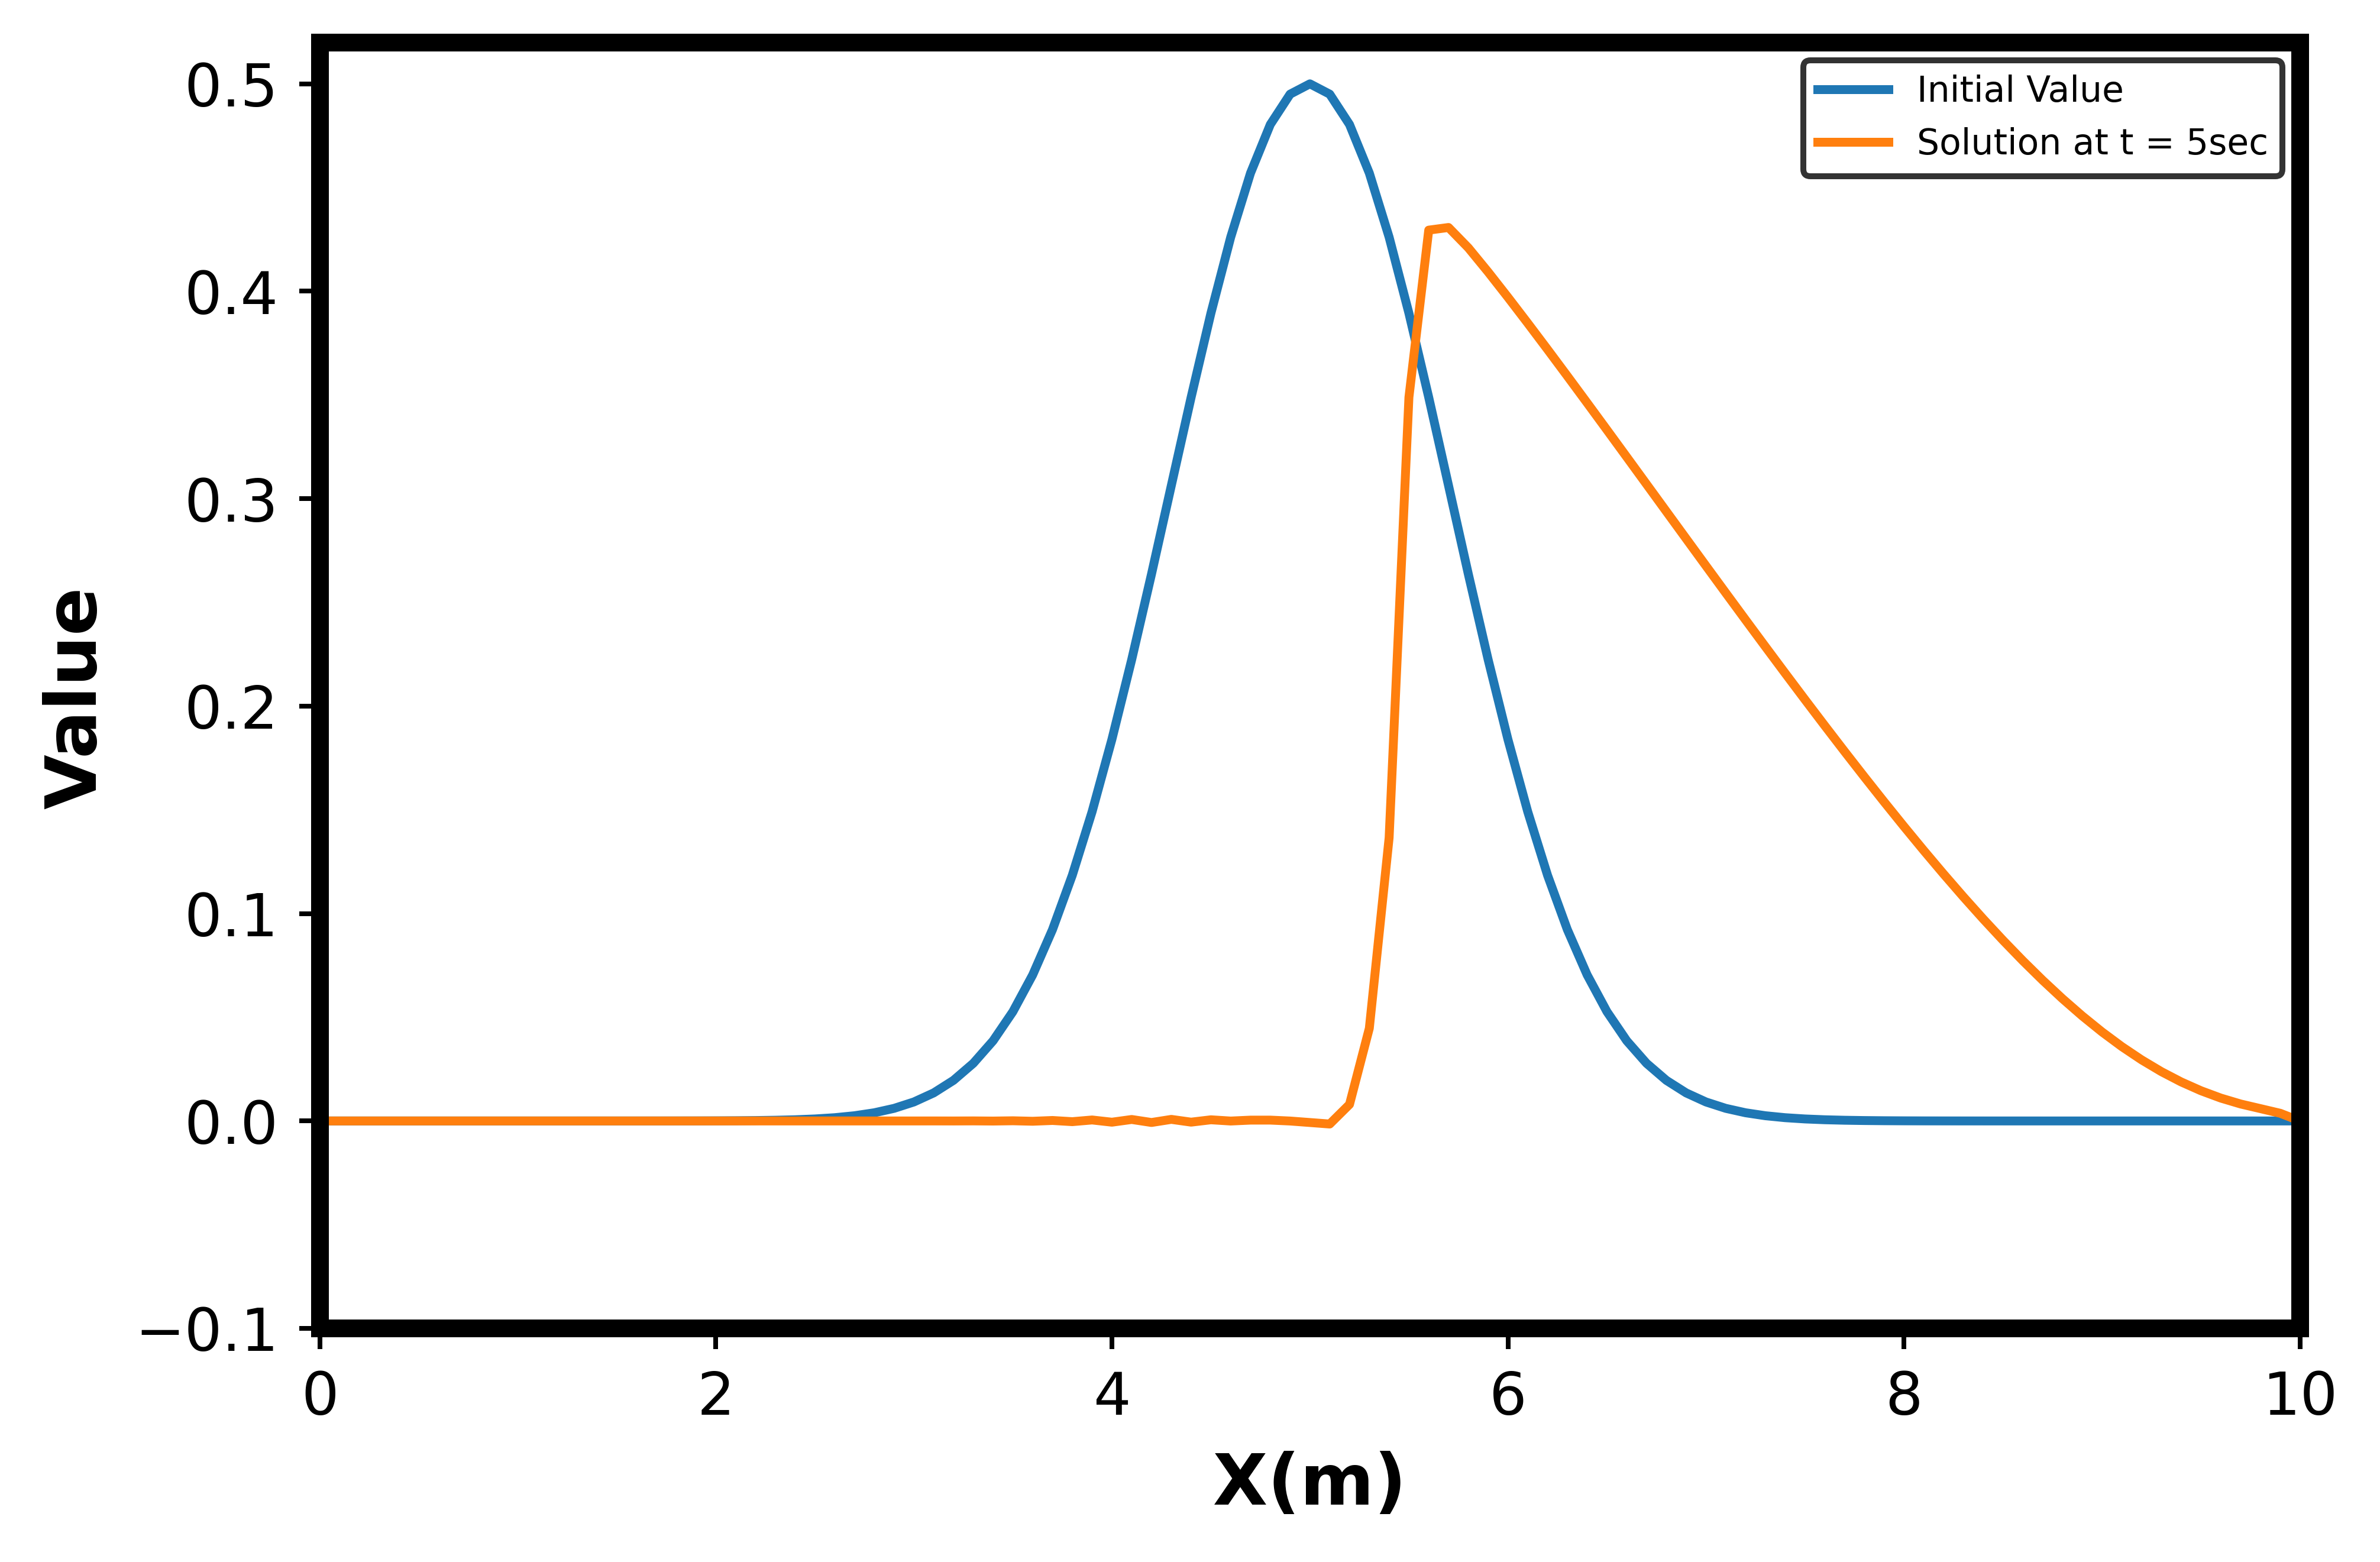

In [12]:
plt.figure(dpi=720)
plt.setp(plt.axes().spines.values(), linewidth=3)
plt.xlabel(' X(m) ',fontsize=12,fontweight='bold')
plt.ylabel('Value ',fontsize=12,fontweight='bold')
plt.xlim(left=0,right=length)
plt.ylim(bottom=-.1,top=.52)
plt.plot(np.linspace(0,length,nx),u_initial,label='Initial Value')
plt.plot(np.linspace(0,length,nx),u, label= 'Solution at t = 5sec')
plt.legend(edgecolor='black',loc='upper right',fontsize=6)

In [14]:
np.amax(u)

0.43074548562046017

In [13]:
pos=np.where(u == np.amax(u))
pos[0]*dx

array([5.7])